In [ ]:
# iplot 라이브러리
import chart_studio
chart_studio.tools.set_credentials_file()
import chart_studio.plotly as py
import plotly.express as px
from chart_studio.plotly import plot, iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import itertools
import pandas as pd
import numpy as np

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from datetime import *
import seaborn as sns
%matplotlib inline

import re
import urllib.request

# 성능지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn.metrics
# 데이터셋 분할 & 교차검증 & 하이퍼파라미터 튜닝
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV


# 회귀분석(통계)
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 표준화
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# 모델링
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 잔차분석
import scipy.stats


# 인코더
from sklearn.preprocessing import LabelEncoder

# 다중공선성 진단
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (14,4)

mpl.rcParams['axes.unicode_minus'] = False

## 1. 이착륙 온실가스 배출량 단순 회귀분석

- IPCC 가이드라인에서는 기종별로 이착륙 단계에서의 온실가스 배출계수를 제공한다. 기종별 배출계수 자료와 세계항공기 정보를 이용해 이착륙시 온실가스 배출계수를 다중선형회귀로 모델링했으며, 변수선택법을 통해 변수를 선정하였다.

### 1) 데이터 불러오기 및 확인

In [ ]:
# 배출계수 데이터(모델링용)
df_coef = pd.read_excel('/Users/dongyokim/main/jupyter/2022:2/Movie_Project/최종 항공 데이터/기종 데이터/11. 전기종별 배출계수.xlsx')
df_coef = df_coef.rename(columns={'승객수':'좌석수'})


df_coef['LTO_emmission(CO2eq)'] = df_coef['LTO_CO2'] + df_coef['LTO_CH4']*21 + df_coef['LTO_N2O']*310


- LTO_CO2, LTO_CH4, LTO_N2O 변수를 조합하여 계산으로 하여 이착륙 온실가스(LTO_emmission(CO2eq)) 배출량 열을 새롭게 추가해주었다.

In [ ]:
df_coef.head()

,기종 2,LTO_CO2,LTO_CH4,LTO_N2O,NOx,CO,NMVOCs,SO2,fuel Consumption (kg/LTO),EF_Cruise_CO2(kg/t of fuel),...,비행기구분,비행기크기,비행기등급,엔진수,조종석수,좌석수,길이(m),높이(m),운송범위(km),LTO_emmission(CO2eq)
0,A300,5450,0.12,0.2,25.86,14.80,1.12,1.72,1720,3150,...,LandPlane,HIGH,Wide-bodyjet airliner,2,3,281,53.6,16.7,5375,5514.52
1,A310,4760,0.63,0.2,19.46,28.30,5.67,1.51,1510,3150,...,LandPlane,HIGH,Wide-bodyjet airliner,2,2,220,46.7,15.8,6500,4835.23
2,A319,2310,0.06,0.1,8.73,6.35,0.54,0.73,730,3150,...,LandPlane,MEDIUM,Narrow-bodyjet airliner,2,2,156,33.8,11.8,6940,2342.26
3,A320,2440,0.06,0.1,9.01,7.55,0.51,0.77,770,3150,...,LandPlane,MEDIUM,Single-aislejet airliner,2,2,186,37.6,12.6,6945,2472.26
4,A330-200,7050,0.13,0.2,35.57,16.20,1.15,2.23,2230,3150,...,LandPlane,HIGH,Wide-bodyjet airliner,2,2,404,58.8,17.4,13427,7114.73


In [ ]:
df_coef.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   기종 2                         36 non-null     object 
 1   LTO_CO2                      36 non-null     int64  
 2   LTO_CH4                      36 non-null     float64
 3   LTO_N2O                      36 non-null     float64
 4   NOx                          36 non-null     float64
 5   CO                           36 non-null     float64
 6   NMVOCs                       36 non-null     float64
 7   SO2                          36 non-null     float64
 8   fuel Consumption (kg/LTO)    36 non-null     int64  
 9   EF_Cruise_CO2(kg/t of fuel)  36 non-null     int64  
 10  EF_Cruise_CH4(kg/t of fuel)  36 non-null     int64  
 11  EF_Cruise_N2O(kg/t of fuel)  36 non-null     float64
 12  Code                         36 non-null     object 
 13  제조사                   

- 총 6개의 범주형 변수와 18개의 연속형 변수로 구성되어 있다.

In [ ]:
print('data의 결측치 : {}'.format(sum(df_coef.isna().sum())))
print()
print(f'data 중복값: {df_coef.duplicated().sum()}, ({np.round(100*df_coef.duplicated().sum()/len(df_coef),1)}%)')

data의 결측치 : 0

data 중복값: 0, (0.0%)


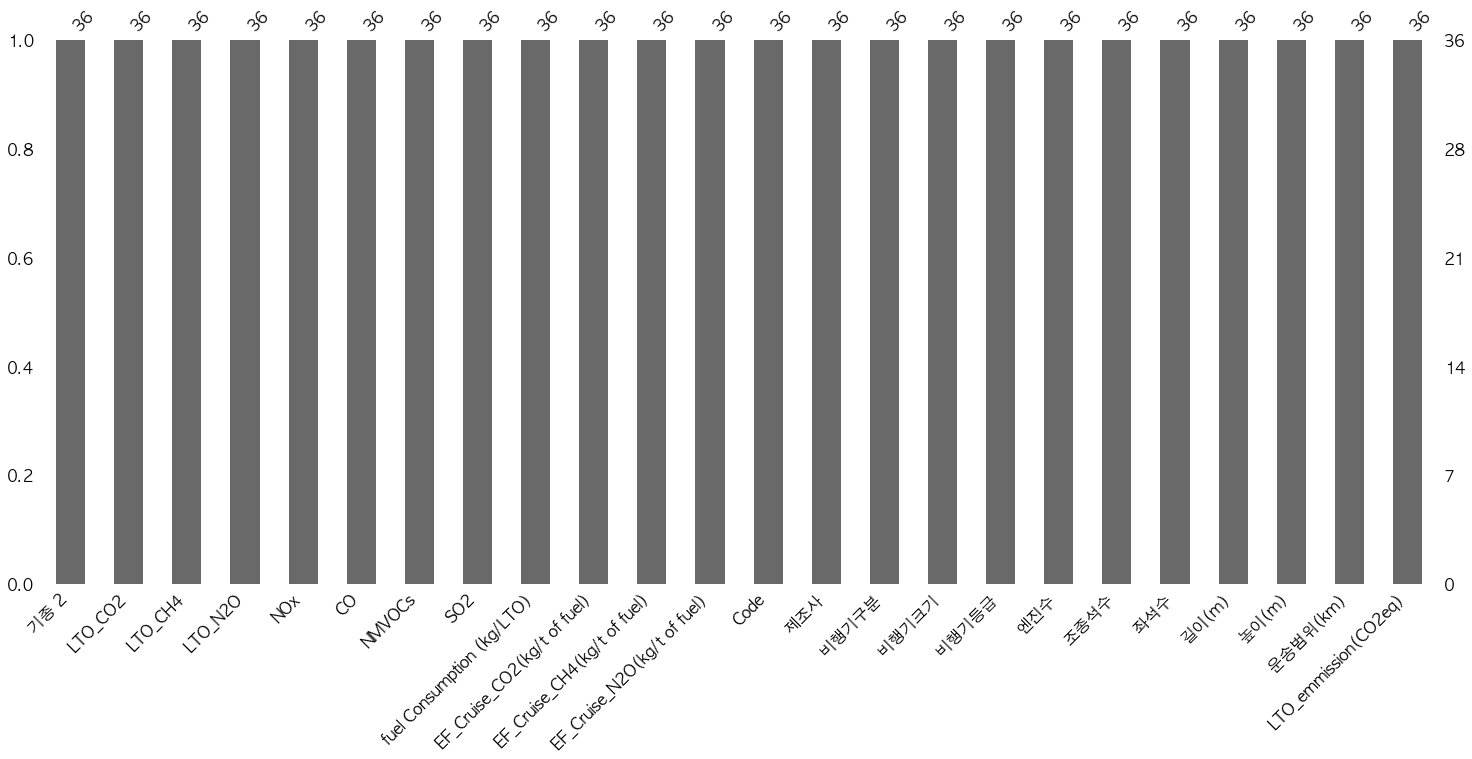

In [ ]:
msno.bar(df_coef)
plt.show()

- 결측치와 중복값이 없는 것을 확인

### 2) EDA(탐색적 데이터 분석)

In [ ]:
# 항공기의 엔진수에 따른 이착륙단계 배출량의 분포
fig=px.box(df_coef,x='LTO_emmission(CO2eq)',y='엔진수',color='엔진수',color_discrete_map={2:'lightgreen',3:'lightpink',4:'lightskyblue'})
fig.update_traces(orientation='h')
fig.update_layout(title='<b>항공기의 엔진수에 따른 이착륙단계 배출량의 분포<b>',title_x=0.5,width=700, height=400)
fig.show()

- 항공기의 엔진수가 2, 3, 4로 늘어남에 따라 이착륙 온실가스 배출량의 boxplot이 전체적으로 오른쪽으로 분포되는 것을 보아, 항공기의 엔진수는 이착륙 온실가스 배출량에 유의한 요인인 것으로 파악할 수 있다.

In [ ]:
fig=px.box(df_coef,x='비행기등급',y='LTO_emmission(CO2eq)',color='비행기등급')
fig.update_layout(title='<b>항공기의 비행기등급에 따른 이착륙단계 배출량의 분포<b>',title_x=0.4,width=800, height=400)
fig.show()

- 비행기등급은 이착륙 온실가스 배출량과의 유의한 상관관계가 보이지 않는다.

In [ ]:
fig = px.scatter(df_coef,
                 x='좌석수',
                 y='LTO_emmission(CO2eq)',
                 color='비행기크기')
fig.update_layout(title='<b> 좌석수와 이착륙단계 배출량의 관계, 비행기크기의 군집화<b>',title_x=0.45,width=800, height=400)
fig.show()

- 좌석수가 많을수록 이착륙단계 배출량이 높아진다는 것을 알 수 있으며,
비행기 크기 또한, 크기가 클수록 이착륙 단계의 배출량이 높아진다.

In [ ]:
fig = px.scatter(df_coef,
                 x='좌석수',
                 y='LTO_emmission(CO2eq)',
                 color='엔진수')
fig.update_layout(title='<b>좌석수와 이착륙단계 배출량의 관계, 엔진수의 군집화<b>',title_x=0.45,width=800, height=400)
fig.show()

- 엔진 수가 4개 이상일 경우 배출량도 높게 나타나는 것을 알 수 있으며, 3개의 군집의 모습을 보여준다.

In [ ]:
fig = px.scatter(df_coef,
                 x='좌석수',
                 y='LTO_emmission(CO2eq)',
                 color='길이(m)')
fig.update_layout(title='<b>좌석수와 이착륙단계 배출량의 관계, 비행기길이의 군집화<b>',title_x=0.45,width=800, height=400)
fig.show()

- 상위 4개의 그래프 모두 x축은 '좌석수', y축은 '이착륙 온실가스 배출량'인 산점도로, 좌석수와 이착륙 온실가스 배출량은 선형 관계가 있다고 볼 수 있다.
- 비행기의 중량과 관련된 요인인 '비행기크기', '조종석수', '비행기길이', '비행기높이'에 따라 색깔이 다른 산점들의 분포에서 각 요인의 수준에 따라 군집성이 4개의 그래프에서 모두 보이므로 '비행기크기', '조종석수', '비행기길이', '비행기높이'는 이착륙 온실가스 배출량에 유의한 요인인 것으로 파악할 수 있다.


In [ ]:
fig=px.scatter_3d(df_coef,
                  x='길이(m)',
                  y='좌석수',
                  z='높이(m)',
                  color='LTO_emmission(CO2eq)',
                  symbol='비행기등급',
                  opacity=0.8)
fig.update_layout(title='<b>항공기별 이착륙단계 온실가스 배출 모형<b>',title_x=0.45,width=1000, height=600)
fig.show()

- 이착륙단계 배출량과 가장 상관관계가 있어보이는 요인들로 3D Scatter 축을 구성하여 항공기별 이착륙 온실가스 배출량 양상을 파악할 수 있다.

### 3) 데이터 전처리

- 다중선형회귀 모델에 필요한 변수들만 추출하였으며, 이착륙단계 배출량를 계산하는데 사용한 변수(LTO_CO2, LTO_CH4, LTO_N2O)를 제외하였다. 또한,  바이오매스의 연소는 CH4 및 N2O 외에도 다양한 온실가스 전구체(CO, NMVOC, NOX 등)가 발생하지만, 지침에 따르면 6대 온실가스에서 제외되었기 때문에, CO, NMVOC, NOX 변수도 제외하였다.

In [ ]:
df_coef = df_coef[['비행기크기','비행기등급','엔진수','조종석수','좌석수','길이(m)','높이(m)','운송범위(km)','LTO_emmission(CO2eq)']]
df_coef.head()

,비행기크기,비행기등급,엔진수,조종석수,좌석수,길이(m),높이(m),운송범위(km),LTO_emmission(CO2eq)
0,HIGH,Wide-bodyjet airliner,2,3,281,53.6,16.7,5375,5514.52
1,HIGH,Wide-bodyjet airliner,2,2,220,46.7,15.8,6500,4835.23
2,MEDIUM,Narrow-bodyjet airliner,2,2,156,33.8,11.8,6940,2342.26
3,MEDIUM,Single-aislejet airliner,2,2,186,37.6,12.6,6945,2472.26
4,HIGH,Wide-bodyjet airliner,2,2,404,58.8,17.4,13427,7114.73


- 범주형 변수를 수치형 변수로 전환해주기 위해 원-핫 인코딩 기법을 사용하여 더미변수로 변환하였다.
- 열이름을 보기 쉽게 변경해주었다.

In [ ]:
# 원-핫 인코딩(비행기 크기, 비행기 등급)
X = pd.get_dummies(df_coef.iloc[:,:8], columns=['비행기크기','비행기등급'], drop_first=True)
y = df_coef['LTO_emmission(CO2eq)']

df = pd.concat([X,y],axis=1)
df.columns = ['engine','pilot_seat','seat', 'length','height','range','size_medium','rank_NBA','rank_NBJ','rank_SAA','rank_WB','rank_WBJ','E_co2eq']
df.head()

,engine,pilot_seat,seat,length,height,range,size_medium,rank_NBA,rank_NBJ,rank_SAA,rank_WB,rank_WBJ,E_co2eq
0,2,3,281,53.6,16.7,5375,0,0,0,0,0,1,5514.52
1,2,2,220,46.7,15.8,6500,0,0,0,0,0,1,4835.23
2,2,2,156,33.8,11.8,6940,1,0,1,0,0,0,2342.26
3,2,2,186,37.6,12.6,6945,1,0,0,1,0,0,2472.26
4,2,2,404,58.8,17.4,13427,0,0,0,0,0,1,7114.73


### 4) 모델링    

In [ ]:
    # 다중선형회귀모형 적합(모든 설명변수로 적합)
    fit = ols('E_co2eq ~ engine + pilot_seat +	seat + length + height + range + size_medium + rank_NBA + rank_NBJ + rank_SAA + rank_WB + rank_WBJ',data=df).fit()
    fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     27.37
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           9.24e-11
Time:                        17:46:25   Log-Likelihood:                -289.20
No. Observations:                  36   AIC:                             604.4
Df Residuals:                      23   BIC:                             625.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9087.9964   2472.006     -3.676      0.001   -1.42e+04   -3974.263
engine        368.0868    291.114      1.264      0.219    -234.129     970.302
pilot_seat   1386.2165    315.531      4.393      0.000     733.491    2038.942
seat            3.5546      3.553      1.000      0.328      -3.795      10.905
length        104.7949     43.898      2.387      0.026      13.985     195.605
height         57.4219     60.965      0.942      0.356     -68.695     183.539
range           0.0986      0.103      0.957      0.349      -0.115       0.312
size_medium  -579.6653   1119.658     -0.518      0.610   -2895.855    1736.524
rank_NBA     2919.8235   1336.715      2.184      0.039     154.618    5685.029
rank_NBJ     2833.5864   1240.373      2.284      0.032     267.679    5399.494
rank_SAA     2621.2734   1607.270      1.631      0.117    -703.617    5946.164
rank_WB      3006.7306   2366.111      1.271      0.217   -1887.943    7901.405
rank_WBJ     2656.3185   1980.053      1.342      0.193   -1439.733    6752.370
==============================================================================
Omnibus:                        5.381   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                4.547
Skew:                          -0.466   Prob(JB):                        0.103
Kurtosis:                       4.471   Cond. No.                     2.30e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 타겟 변수인 E_co2eq를 제외한 모든 변수를 독립변수로 넣어 학습을 시켰을때,
모형의 R-squared 값이 0.935로 종속변수에 대한 독립변수가 설명력이 매우 높게 나타난 것을 알 수 있다. 하지만, 변수가 많을수록 R-squared 값도 높아지는 문제가 있으며, 다중 공선성 문제 등을 일으키므로 결과적으로 추정의 신뢰성을 저하시킬 가능성이 있다.
또한, 독립 변수들 중에 P-value 값이 5%를 넘는 변수들이 다수 보인다.
- 예를 들어, engine 변수의 P-value은 0.219로 5% 보다 큰 것을 알 수 있는데, 이는 곧 engine 변수의 회귀계수가 0 이라는 귀무가설을 기각할 수 있는 임계치보다 t-통계량이 작게 나타났다고 볼 수 있다. 즉, engine 변수의 회귀계수가 0 이라는 귀무가설을 기각할 수 없다.

#### 4-1 성능 개선 방안 1 : 다중공선성이 높은 변수 제거

- 독립 변수 간의 높은 상관 관계를 보이는 것을 다중공선성(Multicollinearity)이라고 한다.
- 다중공선성이 있으면 부정확한 회귀 결과가 도출되며, 독립변수간의 설명력이 중복되기 때문(독립변수간에 상관관계가 있다면 추정한 계수들의 분산이 커짐)에 모형의 전체적인 설명력이 약해진다.
- 다중공선성을 진단하는 방법으로는 다중 회귀 모델에서 독립 변수간 상관 관계가 있는지 측정하는 척도인 VIF 수치를 확인하거나, 독립변수들간의 상관계수 행렬을 도출하여 강한 상관관계를 보이는 독립변수 쌍을 찾으면 된다.

- VIF(분산팽창요인)

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,27.608807,엔진수
1,16.357213,조종석수
2,43.164746,좌석수
3,198.494131,길이(m)
4,29.943133,높이(m)
5,29.050875,운송범위(km)
6,17.366973,비행기크기_MEDIUM
7,12.470109,비행기등급_Narrow-body airliner
8,4.386980,비행기등급_Narrow-bodyjet airliner
9,1.843742,비행기등급_Single-aislejet airliner


- 보통 VIF가 10이 넘으면 다중공선성 있다고 판단하며 5가 넘으면 주의할 필요가 있는 것으로 본다.
- 길이(m)(length) 변수의 VIF 수치가 198로 매우 높게 측정되었으며, 대부분의 변수들이 VIF 수치가 높게 나타났다.
- VIF 수치가 높은 변수들을 제거해주자.

- 히트맵


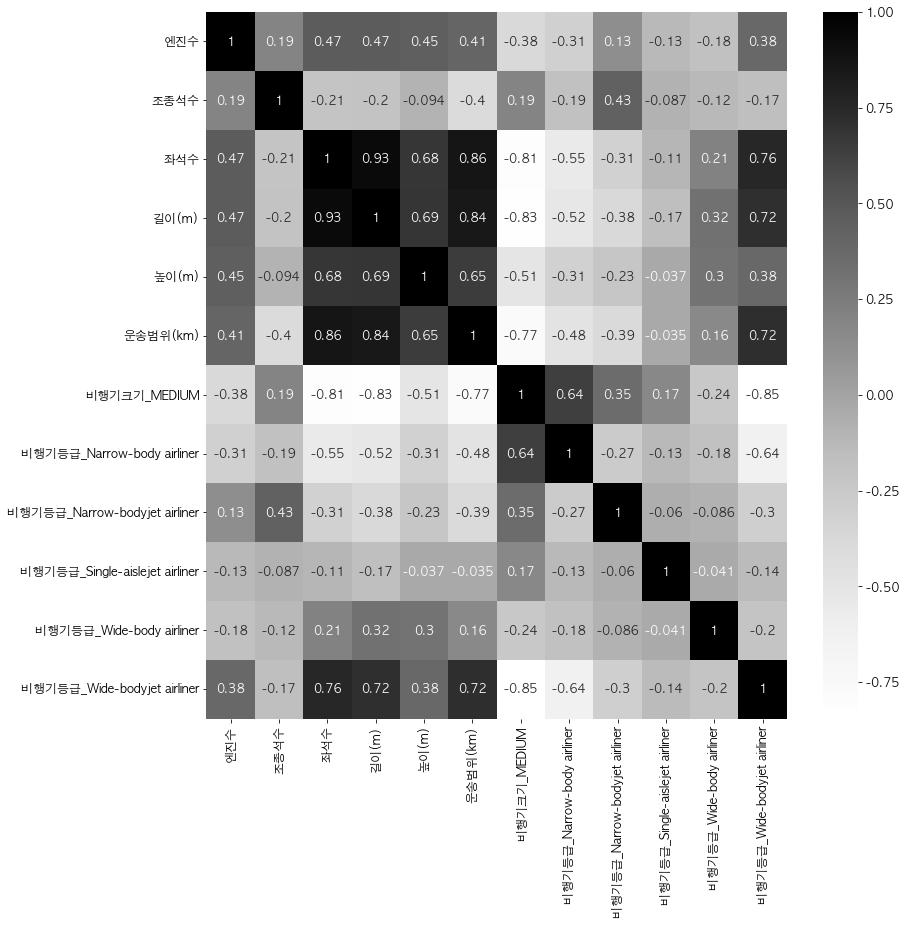

In [ ]:
plt.figure(figsize=(1, 13))
sns.heatmap(X.corr(), annot=True, cmap='Greys')
plt.show()

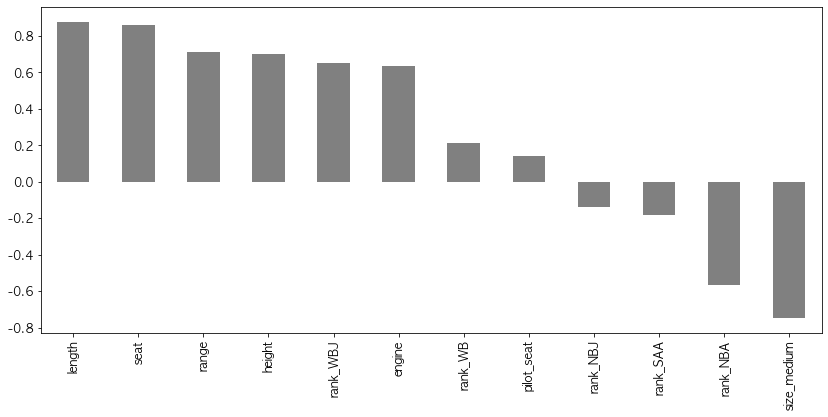

In [ ]:
plt.figure(figsize=(14,6))
corr = df.corr()['E_co2eq'].sort_values(ascending=False)
corr.drop('E_co2eq').plot(kind='bar', color='gray')
plt.show()

In [ ]:
corr

E_co2eq        1.000000
length         0.877107
seat           0.859320
range          0.712930
height         0.700222
rank_WBJ       0.649178
engine         0.633164
rank_WB        0.214530
pilot_seat     0.140402
rank_NBJ      -0.138273
rank_SAA      -0.182321
rank_NBA      -0.563847
size_medium   -0.748681
Name: E_co2eq, dtype: float64

- length(길이), 좌석수(seats) 변수는 다른 대부분의 독립변수들간의 상관관계가 매우 크게 나타나기 때문에, 다중공선성의 위험이 있다. 또한, 길이(length), 좌석수(seats) 변수 간의 상관계수가 0.93으로 다른 변수들의 상관계수에 비해 가장 크기 떄문에, 길이(length), 좌석수(seats) 변수 중에 하나의 변수를 삭제해주는 것이 좋아보인다.
- length, seat, size_medium  등의 변수가 이착륙 온실가스 배출량 변수(E_co2eq)와 강한 상관관계를 보이고 있다.

In [ ]:
# length 변수를 제거한 상태로 VIF 측정
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df.drop(['length' ,'E_co2eq'], axis=1).values, i) for i in range(df.drop(['length' ,'E_co2eq'], axis=1).shape[1])]
vif["features"] = df.drop(['length' ,'E_co2eq'], axis=1).columns
vif

,VIF Factor,features
0,22.662714,engine
1,13.058656,pilot_seat
2,32.050745,seat
3,29.941005,height
4,26.287996,range
5,13.935135,size_medium
6,10.116848,rank_NBA
7,4.384961,rank_NBJ
8,1.802207,rank_SAA
9,3.295228,rank_WB


- length 변수를 제거한 상태로 VIF 수치를 측정한 결과 변수들의 VIF 수치가 전체적으로 감소한 것을 알 수 있다.

-  다중공선성을 보이는 변수들과 p-value 값이 높은 변수들을 제외(length, size_medium, height)해준 상태로 다중선형회귀 모형 적합

In [ ]:
# 다중선형회귀모형 적합(다중공선성을 보이는 변수를 제거하고 선택)
fit_2 = ols('E_co2eq ~ engine + pilot_seat + seat + range + rank_NBA + rank_NBJ + rank_SAA + rank_WB + rank_WBJ',data=df).fit()
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     31.24
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.02e-11
Time:                        14:20:50   Log-Likelihood:                -293.83
No. Observations:                  36   AIC:                             607.7
Df Residuals:                      26   BIC:                             623.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7411.3842   1854.677     -3.996      0.000   -1.12e+04   -3599.042
engine       704.7916    261.091      2.699      0.012     168.112    1241.471
pilot_seat  1551.0817    319.242      4.859      0.000     894.870    2207.293
seat           8.8748      2.983      2.975      0.006       2.743      15.007
range          0.1666      0.103      1.623      0.117      -0.044       0.377
rank_NBA    3322.6742   1374.099      2.418      0.023     498.174    6147.174
rank_NBJ    2407.7071   1296.419      1.857      0.075    -257.121    5072.535
rank_SAA    2564.3576   1673.693      1.532      0.138    -875.967    6004.683
rank_WB     5694.8279   1705.094      3.340      0.003    2189.958    9199.698
rank_WBJ    4011.4847   1524.832      2.631      0.014     877.147    7145.823
==============================================================================
Omnibus:                       12.819   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.560
Skew:                          -0.777   Prob(JB):                     2.08e-05
Kurtosis:                       6.458   Cond. No.                     1.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 이전보다 R-squared 수치가 약간 줄어들었지만, 높은 P-value 값을 보이는 변수들이 큰 폭으로 줄었다.
- 예를 들어 이전에 모든 독립변수 이용하여 모델링을 진행할 때는 engine 변수의 P-value 값이 0.219로 5% 이상의 수치를 나타내기 때문에 귀무가설을 기각할 수 없었지만, 3개의 변수를 삭제한다음에 결과를 보면 engine 변수의 P-value 값이 0.012로 크게 줄은 것을 알 수 있다.
- 즉 ,t-통계량이 임계치보다 높게 나타나 유의 수준이 5% 이하로 유의하며, engine 변수의 회귀계수가 0이라는 귀무가설을 기각할 수 있다.

#### 4-2 성능 개선 방안 2 : 변수선택법을 활용한 최적의 변수 조합 탐색

- 변수선택법은 다중선형회귀분석을 할때, 최적의 변수 조합을 찾아내는 기법을 말한다.
- 변수의 모든 조합을 계산하는 것은 많은 시간이 소요되기 때문에 합리적인 변수 선택 기법의 종류인 전진선택법, 후진소거법, 단계적선택법을 활용하여 가장 높은 성능을 보여주는 모델을 찾을 수 있다 .
- 다양한 변수선택법을 사용하여 모델의 상대적인 품질을 평가하는 AIC 수치를 기준으로 가장 낮은 수치를 보여주는 변수의 조합을 찾을 수 있다. 모형의 적합도를 나타내는 AIC 수치를 기준으로 가장 최소의 정보 손실을 갖는 모델이 가장 데이터와 적합한 모델로 선택되는 방식으로 진행된다. AIC 값이 낮다는 것은 모형의 적합도가 높은 것을 의미한다.


![image.png](attachment:image.png)

In [ ]:
X = df.drop('E_co2eq', axis=1)
# bias 추가
X = sm.add_constant(X, has_constant='add')
y = df['E_co2eq']

In [ ]:
# 변수 선택법을 위한 함수 구현
def processSubset(X,y, feature_set):
            model = sm.OLS(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}

print(processSubset(X=X, y=y, feature_set = X.columns))

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x138364c10>, 'AIC': 604.3947861700035}


##### 전진선택법(Feedforward Selection)

In [ ]:
########전진선택법(step=1)

def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

In [ ]:
#### 전진선택법 모델

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    return(Fmodels['model'][len(Fmodels['model'])])

In [ ]:
Forward_best_model = forward_model(X=X, y=y)

Selected predictors: ['length', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383a91f0>
Selected predictors: ['length', 'pilot_seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383a9c10>
Selected predictors: ['length', 'pilot_seat', 'engine', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383a9550>
Selected predictors: ['length', 'pilot_seat', 'engine', 'seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383b6ac0>
Selected predictors: ['length', 'pilot_seat', 'engine', 'seat', 'height', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383a9b80>
Selected predictors: ['length', 'pilot_seat', 'engine', 'seat', 'height', 'size_medium', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383b6a00>


- AIC 수치를 기준으로 전진선택법을 사용하여 최종적으로  ['length', 'pilot_seat', 'engine', 'seat', 'height'] 변수를 선택하였다.

In [ ]:
# aic 수치
Forward_best_model.aic

599.7924729256008

In [ ]:
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     64.61
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           3.78e-15
Time:                        14:20:50   Log-Likelihood:                -293.90
No. Observations:                  36   AIC:                             599.8
Df Residuals:                      30   BIC:                             609.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
length       112.1791     33.135      3.386      0.002      44.509     179.849
pilot_seat   959.2960    195.129      4.916      0.000     560.789    1357.803
engine       500.4034    215.882      2.318      0.027      59.512     941.294
seat           5.7969      2.987      1.941      0.062      -0.304      11.897
height        77.0297     54.233      1.420      0.166     -33.730     187.789
const      -6486.6299   1096.346     -5.917      0.000   -8725.667   -4247.593
==============================================================================
Omnibus:                        1.711   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                0.730
Skew:                          -0.128   Prob(JB):                        0.694
Kurtosis:                       3.649   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#####  후진소거법(Backward Elimination)

In [ ]:
######## 후진선택법(step=1)
def backward(X,y,predictors):
    results = []
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

In [ ]:
def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    return (Bmodels['model'].dropna().iloc[0])

In [ ]:
Backward_best_model = backward_model(X=X,y=y)

Selected predictors: ['engine', 'height', 'length', 'pilot_seat', 'range', 'rank_NBA', 'rank_NBJ', 'rank_SAA', 'rank_WB', 'rank_WBJ', 'seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383e02b0>
Selected predictors: ['engine', 'length', 'pilot_seat', 'range', 'rank_NBA', 'rank_NBJ', 'rank_SAA', 'rank_WB', 'rank_WBJ', 'seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383ed0a0>
Selected predictors: ['engine', 'length', 'pilot_seat', 'range', 'rank_NBA', 'rank_NBJ', 'rank_SAA', 'rank_WB', 'rank_WBJ', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383f2f40>
Selected predictors: ['length', 'pilot_seat', 'range', 'rank_NBA', 'rank_NBJ', 'rank_SAA', 'rank_WB', 'rank_WBJ', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383edc10>


- AIC 수치를 기준으로 후진소거법을 사용하여 최종적으로 ['engine', 'length', 'pilot_seat', 'range', 'rank_NBA', 'rank_NBJ', 'rank_SAA', 'rank_WB', 'rank_WBJ'] 변수를 선택하였다.

In [ ]:
Backward_best_model.aic

601.6267258000174

In [ ]:
Backward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     37.46
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.21e-12
Time:                        14:20:50   Log-Likelihood:                -290.81
No. Observations:                  36   AIC:                             601.6
Df Residuals:                      26   BIC:                             617.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
engine       446.2875    258.247      1.728      0.096     -84.547     977.121
length       131.6055     33.759      3.898      0.001      62.213     200.998
pilot_seat  1535.6370    290.598      5.284      0.000     938.305    2132.969
range          0.1718      0.089      1.937      0.064      -0.011       0.354
rank_NBA    3559.9166   1234.416      2.884      0.008    1022.538    6097.295
rank_NBJ    3328.4489   1164.083      2.859      0.008     935.642    5721.256
rank_SAA    3336.9056   1506.216      2.215      0.036     240.834    6432.977
rank_WB     4357.8161   1682.125      2.591      0.015     900.158    7815.474
rank_WBJ    3829.7621   1373.359      2.789      0.010    1006.782    6652.742
const      -1.097e+04   1723.830     -6.364      0.000   -1.45e+04   -7426.471
==============================================================================
Omnibus:                        6.023   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                4.531
Skew:                          -0.780   Prob(JB):                        0.104
Kurtosis:                       3.765   Cond. No.                     1.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#####  단계적선택법(Stepwise)

In [ ]:
######## 단계적선택법(step=1)
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [ ]:
Stepwise_best_model=Stepwise_model(X=X,y=y)

Selected predictors: ['length', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1383f27f0>
forward
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x138407f10>
Selected predictors: ['length', 'pilot_seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1384076a0>
forward
Selected predictors: ['length', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x138400d30>
Selected predictors: ['length', 'pilot_seat', 'engine', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1384003d0>
forward
Selected predictors: ['length', 'pilot_seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1384004f0>
Selected predictors: ['length', 'pilot_seat', 'engine', 'seat', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper o

- AIC 수치를 기준으로 단계적선택법을 사용하여 최종적으로 ['length', 'pilot_seat', 'engine', 'seat', 'height'] 변수를 선택하였다.

In [ ]:
Stepwise_best_model.aic

599.7924729256008

In [ ]:
Stepwise_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     64.61
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           3.78e-15
Time:                        14:20:50   Log-Likelihood:                -293.90
No. Observations:                  36   AIC:                             599.8
Df Residuals:                      30   BIC:                             609.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
length       112.1791     33.135      3.386      0.002      44.509     179.849
pilot_seat   959.2960    195.129      4.916      0.000     560.789    1357.803
engine       500.4034    215.882      2.318      0.027      59.512     941.294
seat           5.7969      2.987      1.941      0.062      -0.304      11.897
height        77.0297     54.233      1.420      0.166     -33.730     187.789
const      -6486.6299   1096.346     -5.917      0.000   -8725.667   -4247.593
==============================================================================
Omnibus:                        1.711   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                0.730
Skew:                          -0.128   Prob(JB):                        0.694
Kurtosis:                       3.649   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### 성능평가

In [ ]:
# 모델에 의해 예측된/추정된 값 <->  test_y
# 모든 변수 사용 모델


# 다중공선성 보이는 변수 제거 모델
pred_y_full_2 = fit_2.predict(X)

# 전진선택법
pred_y_forward = Forward_best_model.predict(X[Forward_best_model.model.exog_names])

# 후진소거법
pred_y_backward = Backward_best_model.predict(X[Backward_best_model.model.exog_names])

# 단계적선택법
pred_y_stepwise = Stepwise_best_model.predict(X[Stepwise_best_model.model.exog_names])

perf_mat = pd.DataFrame(columns=["Multi_MODEL", "FORWARD", "BACKWARD", "STEPWISE"],
                        index =['MSE', 'RMSE','MAE', 'MAPE'])


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



# 성능지표
perf_mat.loc['MSE']['Multi_MODEL'] = mean_squared_error(y,pred_y_full_2)
perf_mat.loc['MSE']['FORWARD'] = mean_squared_error(y,pred_y_forward)
perf_mat.loc['MSE']['BACKWARD'] = mean_squared_error(y,pred_y_backward)
perf_mat.loc['MSE']['STEPWISE'] = mean_squared_error(y,pred_y_stepwise)

perf_mat.loc['RMSE']['Multi_MODEL'] = np.sqrt(mean_squared_error(y, pred_y_full_2))
perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(mean_squared_error(y, pred_y_forward))
perf_mat.loc['RMSE']['BACKWARD'] = np.sqrt(mean_squared_error(y, pred_y_backward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(mean_squared_error(y, pred_y_stepwise))

perf_mat.loc['MAE']['Multi_MODEL'] = mean_absolute_error(y, pred_y_full_2)
perf_mat.loc['MAE']['FORWARD'] = mean_absolute_error(y, pred_y_forward)
perf_mat.loc['MAE']['BACKWARD'] = mean_absolute_error(y, pred_y_backward)
perf_mat.loc['MAE']['STEPWISE'] = mean_absolute_error(y, pred_y_stepwise)

perf_mat.loc['MAPE']['Multi_MODEL'] = mean_absolute_percentage_error(y, pred_y_full_2)
perf_mat.loc['MAPE']['FORWARD'] = mean_absolute_percentage_error(y, pred_y_forward)
perf_mat.loc['MAPE']['BACKWARD'] = mean_absolute_percentage_error(y, pred_y_backward)
perf_mat.loc['MAPE']['STEPWISE'] = mean_absolute_percentage_error(y, pred_y_stepwise)


In [ ]:
perf_mat.style

,Multi_MODEL,FORWARD,BACKWARD,STEPWISE
MSE,719096.858991,721935.895090,608298.425826,721935.895090
RMSE,847.995789,849.668109,779.934886,849.668109
MAE,540.803655,641.952391,604.789707,641.952391
MAPE,9.327583,13.689692,12.307087,13.689692


- RMSE, MSE 면에서 후진소거법을 통해 도출한 변수가 가장 성능이 높게 나온다. RMSE는 큰 오류값에 패널티를 크게 주는 장점이 있기 때문에, 성능지표로서 유용함
- MAE, MAPE 면에서는 위에서 VIF 수치가 높은 변수들을 제외하고 구현한 Multi_MODEL이 가장 성능이 높게 나온다.

In [ ]:
# 후진 소거법 모형 요약 결과
Backward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     37.46
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.21e-12
Time:                        14:20:50   Log-Likelihood:                -290.81
No. Observations:                  36   AIC:                             601.6
Df Residuals:                      26   BIC:                             617.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
engine       446.2875    258.247      1.728      0.096     -84.547     977.121
length       131.6055     33.759      3.898      0.001      62.213     200.998
pilot_seat  1535.6370    290.598      5.284      0.000     938.305    2132.969
range          0.1718      0.089      1.937      0.064      -0.011       0.354
rank_NBA    3559.9166   1234.416      2.884      0.008    1022.538    6097.295
rank_NBJ    3328.4489   1164.083      2.859      0.008     935.642    5721.256
rank_SAA    3336.9056   1506.216      2.215      0.036     240.834    6432.977
rank_WB     4357.8161   1682.125      2.591      0.015     900.158    7815.474
rank_WBJ    3829.7621   1373.359      2.789      0.010    1006.782    6652.742
const      -1.097e+04   1723.830     -6.364      0.000   -1.45e+04   -7426.471
==============================================================================
Omnibus:                        6.023   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                4.531
Skew:                          -0.780   Prob(JB):                        0.104
Kurtosis:                       3.765   Cond. No.                     1.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

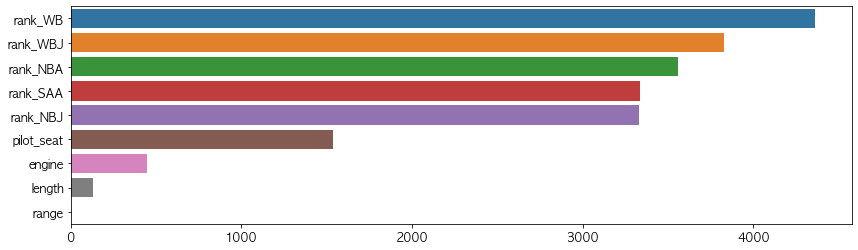

In [ ]:
# 회귀계수 높은 순으로 도출
coef = pd.Series(list(Backward_best_model.params[:-1]), index=Backward_best_model.params.index[:-1])
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

- Adj. R-squared:0.904 로 적합된 회귀 모형이 데이터를 잘 설명한다고 볼 수 있다.
- 여러 번의 변수 선택 후 남은 변수들 대부분이 유의수준 1%에서 유의하다.
- 엔진수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 446.29 kg(CO2-eq)가 증가한다.
- 조종석수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 1535.64 kg(CO2-eq)가 증가한다.
- 항공기 길이가 1m 증가하면, 이착륙시 온실가스 배출량은 약 131.61 kg(CO2-eq)가 증가한다.

In [ ]:
def residual_model(model, y):

    # 잔차 진단
    fitted = model.predict()
    residual = np.array(y) - fitted

    sr = scipy.stats.zscore(residual)
    (x, y), _ = scipy.stats.probplot(sr)


    plt.figure(figsize=(21,7))

    # 잔차 대 적합치 : 모델의 선형성
    plt.subplot(1,3,1)
    sns.regplot(x=fitted, y=residual, lowess=True, line_kws={'color': 'red'})
    plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='grey')
    plt.title("Residuals vs Fitted")
    plt.xlabel("Fitted Value")
    plt.ylabel("Residual")

    # Q-Q플랏 : 잔차의 정규성
    plt.subplot(1,3,2)
    sns.scatterplot(x, y)
    plt.plot([-3, 3], [-3, 3], '--', color='grey')
    plt.title("Normal Q-Q")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")

    # 표준화 잔차 : 잔차의 등분산성
    plt.subplot(1,3,3)
    sns.regplot(x=fitted, y=np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})
    plt.title("Standardized Residual")

    plt.show()

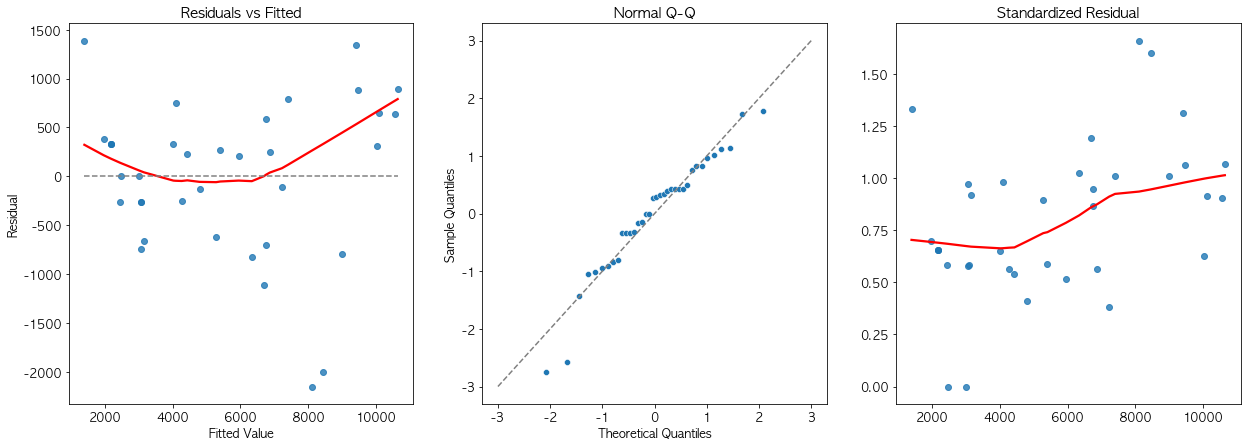

In [ ]:
residual_model(Backward_best_model, y)

1. 모형의 선형성 : 잔차 대 적합치 그래프를 봤을 때, 0을 중심으로 점들이 랜덤하게 분포하기 때문에 선형성 가정을 만족한다고 할 수 있다.
2. 잔차의 정규성 : Normal Q-Q 플랏에서, 점들의 분포가 직선을 크게 벗어나지 않았기 때문에 정규성 가정을 만족한다고 할 수 있다.
3. 잔차의 등분산성 : 0을 중심으로 표준화 잔차가 랜덤하게 분포하고 있기 때문에 등분산 가정을 만족한다고 할 수 있다.


In [ ]:
# 전진선택법(단계적선택법과 동일)
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     64.61
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           3.78e-15
Time:                        14:20:51   Log-Likelihood:                -293.90
No. Observations:                  36   AIC:                             599.8
Df Residuals:                      30   BIC:                             609.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
length       112.1791     33.135      3.386      0.002      44.509     179.849
pilot_seat   959.2960    195.129      4.916      0.000     560.789    1357.803
engine       500.4034    215.882      2.318      0.027      59.512     941.294
seat           5.7969      2.987      1.941      0.062      -0.304      11.897
height        77.0297     54.233      1.420      0.166     -33.730     187.789
const      -6486.6299   1096.346     -5.917      0.000   -8725.667   -4247.593
==============================================================================
Omnibus:                        1.711   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                0.730
Skew:                          -0.128   Prob(JB):                        0.694
Kurtosis:                       3.649   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

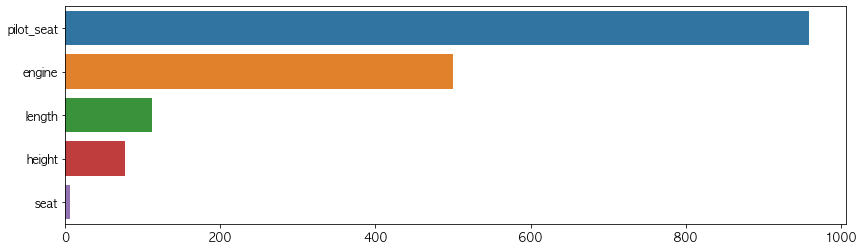

In [ ]:
# 회귀계수 높은 순으로 도출
coef = pd.Series(list(Forward_best_model.params[:-1]), index=Forward_best_model.params.index[:-1])
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

- Adj. R-squared:0.901로 적합된 회귀 모형이 데이터를 잘 설명한다고 볼 수 있다.
- 여러 번의 변수 선택 후 height 변수를 제외한 남은 변수들이 대부분이 유의수준 1%에서 유의하다.
- 엔진수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 500.40kg(CO2-eq)가 증가한다.
- 조종석수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 959.3kg(CO2-eq)가 증가한다.
- 좌석수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 5.80kg(CO2-eq)가 증가한다.
- 항공기 길이가 1m 증가하면, 이착륙시 온실가스 배출량은 약 112.18kg(CO2-eq)가 증가한다.
- 항공기 높이가 1m 증가하면, 이착륙시 온실가스 배출량은 약 77.03kg(CO2-eq)가 증가한다.

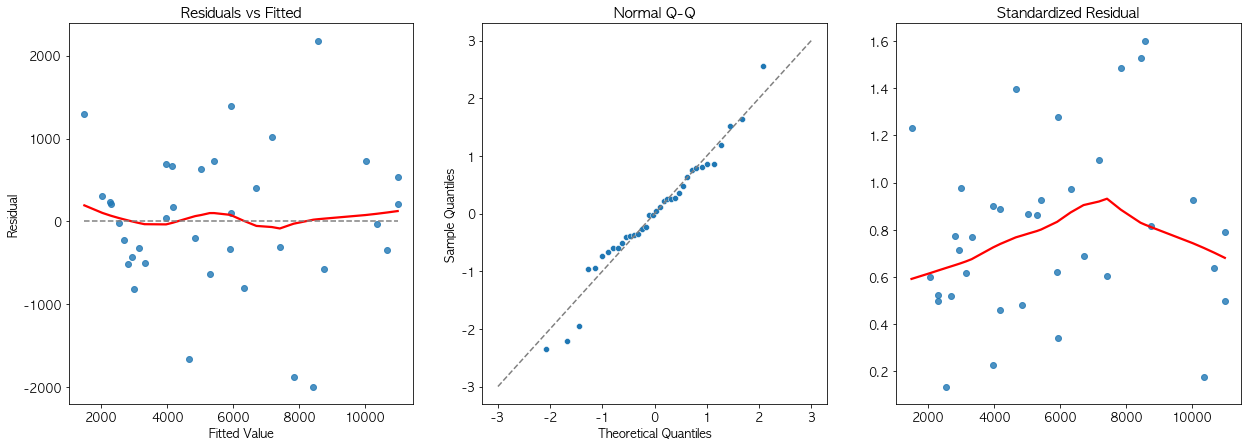

In [ ]:
residual_model(Forward_best_model, y)

1. 모형의 선형성 : 잔차 대 적합치 그래프를 봤을 때, 0을 중심으로 점들이 랜덤하게 분포하기 때문에 선형성 가정을 만족한다고 할 수 있다.
2. 잔차의 정규성 : Normal Q-Q 플랏에서, 점들의 분포가 직선을 크게 벗어나지 않았기 때문에 정규성 가정을 만족한다고 할 수 있다.
3. 잔차의 등분산성 : 0을 중심으로 표준화 잔차가 랜덤하게 분포하고 있기 때문에 등분산 가정을 만족한다고 할 수 있다.


In [ ]:
# 개선안 1에서 구현한 모형(다중공선성이 보이는 변수 삭제)
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                E_co2eq   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     31.24
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.02e-11
Time:                        14:20:51   Log-Likelihood:                -293.83
No. Observations:                  36   AIC:                             607.7
Df Residuals:                      26   BIC:                             623.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7411.3842   1854.677     -3.996      0.000   -1.12e+04   -3599.042
engine       704.7916    261.091      2.699      0.012     168.112    1241.471
pilot_seat  1551.0817    319.242      4.859      0.000     894.870    2207.293
seat           8.8748      2.983      2.975      0.006       2.743      15.007
range          0.1666      0.103      1.623      0.117      -0.044       0.377
rank_NBA    3322.6742   1374.099      2.418      0.023     498.174    6147.174
rank_NBJ    2407.7071   1296.419      1.857      0.075    -257.121    5072.535
rank_SAA    2564.3576   1673.693      1.532      0.138    -875.967    6004.683
rank_WB     5694.8279   1705.094      3.340      0.003    2189.958    9199.698
rank_WBJ    4011.4847   1524.832      2.631      0.014     877.147    7145.823
==============================================================================
Omnibus:                       12.819   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.560
Skew:                          -0.777   Prob(JB):                     2.08e-05
Kurtosis:                       6.458   Cond. No.                     1.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
fit_2.params

Intercept    -7411.384238
engine         704.791584
pilot_seat    1551.081722
seat             8.874769
range            0.166571
rank_NBA      3322.674238
rank_NBJ      2407.707105
rank_SAA      2564.357628
rank_WB       5694.827921
rank_WBJ      4011.484666
dtype: float64

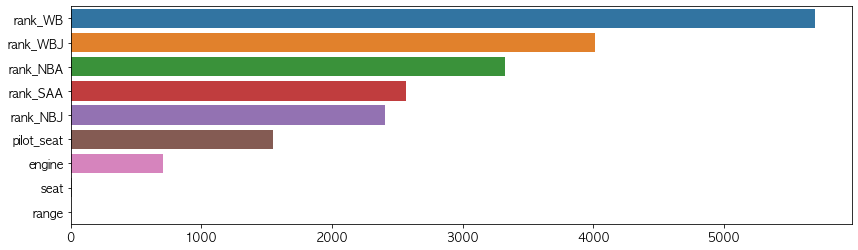

In [ ]:
# 회귀계수 높은 순으로 도출
coef = pd.Series(list(fit_2.params[1:]), index=fit_2.params.index[1:])
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

- Adj. R-squared:0.886로 변수선택법으로 구현한 모형보다는 설명력이 약간 낮지만, 데이터를 잘 설명한다고 볼 수 있다.
- 여러 번의 변수 선택 후 range, rank_SAA 변수를 제외한 남은 변수들이 대부분이 유의수준 5%에서 유의하다.
- 엔진수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 704.79kg(CO2-eq)가 증가한다.
- 조종석수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 1551.08kg(CO2-eq)가 증가한다.
- 좌석수가 1개 증가하면, 이착륙시 온실가스 배출량은 약 8.87kg(CO2-eq)가 증가한다.


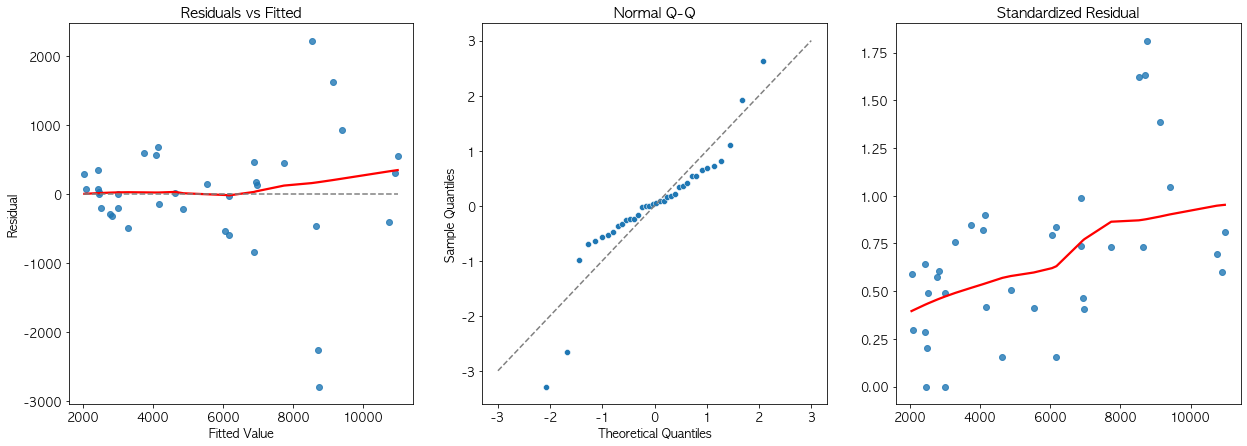

In [ ]:
residual_model(fit_2, y)

1. 모형의 선형성 : 잔차 대 적합치 그래프를 봤을 때, 0을 중심으로 점들이 랜덤하게 분포하기 때문에 선형성 가정을 만족한다고 할 수 있다.
2. 잔차의 정규성 : Normal Q-Q 플랏에서, 점들의 분포가 직선을 크게 벗어나지 않았기 때문에 정규성 가정을 만족한다고 할 수 있다.
3. 잔차의 등분산성 : 우상향하는 약간의 잔차의 추세가 보이지만, 0을 중심으로 표준화 잔차가 랜덤하게 분포하고 있기 때문에 등분산 가정을 만족한다고 할 수 있다.

## 2. 항공 스케줄 데이터를 활용하여 총 온실가스 배출량 수치 예측

- 항공 스케줄 데이터의 구체적인 전처리 과정은 <항공 스케줄 데이터 전처리 코드.ipynb> 파일에 수록되어 있다.

### 1) 데이터 불러오기 및 확인

In [ ]:
# 김포-제주 데이터
data_1 = pd.read_excel('/Users/dongyokim/main/jupyter/2022:2/Movie_Project/분석/eda용 최종 데이터.xlsx', index_col=0)

# 김포-김해 데이터
data_2 = pd.read_excel('/Users/dongyokim/main/jupyter/2022:2/Movie_Project/분석/eda용 최종 데이터(김포-부산).xlsx', index_col=0)

# 제주-김해 데이터
data_3 = pd.read_excel('/Users/dongyokim/main/jupyter/2022:2/Movie_Project/분석/eda용 최종 데이터(제주-부산).xlsx', index_col=0)


In [ ]:
# 행 기준으로 병합
total_data = pd.concat([data_1, data_2, data_3])

# 중복 삭제
total_data.drop_duplicates(keep='first', inplace=True )

# 인덱스 초기화
total_data.reset_index(drop=True, inplace=True)



In [ ]:
total_data.to_excel('EDA 노선 총합.xlsx')

In [ ]:
total_data.head()

,기종(좌석수),운항편명,항공사,출발공항,도착공항,출발시간,도착시간,운항일자,운항시간,기종,...,total_fuel(kg),CO2(kgCO2eq),CH4(kgCO2eq),N2O(kgCO2eq),total_emmission(kgCO2eq),연도,월,출발시각,도착시각,요일
0,A321-200(195),OZ8903,아시아나항공,GMP,CJU,610,720,2018-01-01,70,A321-200,...,2580.89,8125.8035,0.14,50.34759,8176.29109,2018,1,6,7,0
1,A321-neo(180),OZ8903,아시아나항공,GMP,CJU,610,720,2018-01-01,70,A321-neo,...,2441.70,7687.3550,0.14,46.03270,7733.52770,2018,1,6,7,0
2,B767-300(290),OZ8903,아시아나항공,GMP,CJU,610,720,2018-01-01,70,B767-300,...,4253.99,13403.0685,0.12,76.89369,13480.08219,2018,1,6,7,0
3,A321-200(195),OZ8923,아시아나항공,GMP,CJU,940,1050,2018-01-01,70,A321-200,...,2580.89,8125.8035,0.14,50.34759,8176.29109,2018,1,9,10,0
4,A321-neo(180),OZ8923,아시아나항공,GMP,CJU,940,1050,2018-01-01,70,A321-neo,...,2441.70,7687.3550,0.14,46.03270,7733.52770,2018,1,9,10,0


In [ ]:
print('data shape : {}'.format(total_data.shape))
print('data shape : {}'.format(total_data.shape))
print(f'data 중복값: {total_data.duplicated().sum()}, ({np.round(100*total_data.duplicated().sum()/len(total_data),5)}%)')

data shape : (15515, 33)
data shape : (15515, 33)
data 중복값: 0, (0.0%)


In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15515 entries, 0 to 15514
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   기종(좌석수)                   15515 non-null  object 
 1   운항편명                      15515 non-null  object 
 2   항공사                       15515 non-null  object 
 3   출발공항                      15515 non-null  object 
 4   도착공항                      15515 non-null  object 
 5   출발시간                      15515 non-null  int64  
 6   도착시간                      15515 non-null  int64  
 7   운항일자                      15515 non-null  object 
 8   운항시간                      15515 non-null  int64  
 9   기종                        15515 non-null  object 
 10  제조사                       15515 non-null  object 
 11  좌석수                       15515 non-null  int64  
 12  길이(m)                     15515 non-null  float64
 13  날개 폭(m)                   15515 non-null  float64
 14  높이(m) 

In [ ]:
numerical_feats = list(total_data.select_dtypes(exclude='object'))

print('Dataset의 수치형 변수는 총 {}개 입니다.'.format(len(numerical_feats)))


cat_feats = list(total_data.select_dtypes(include='object'))

print('Dataset의 범주형 변수는 총 {}개 입니다.'.format(len(cat_feats)))

Dataset의 수치형 변수는 총 24개 입니다.
Dataset의 범주형 변수는 총 9개 입니다.


### 2) EDA(탐색적 데이터 분석)

- 태블로로 시각화 진행

In [ ]:
## 모델에 필요한 독립 변수만 추출
total_data = total_data[['항공사', '출발공항', '도착공항',
                '운항시간', '제조사',
                '좌석수','길이(m)',  '날개 폭(m)', '높이(m)',
                '순항속도(km/h)', '전체여객', '운항거리', '연도', 'total_emmission(kgCO2eq)']]

numerical_feats = list(total_data.select_dtypes(exclude='object'))
cat_feats = list(total_data.select_dtypes(include='object'))

<AxesSubplot:>

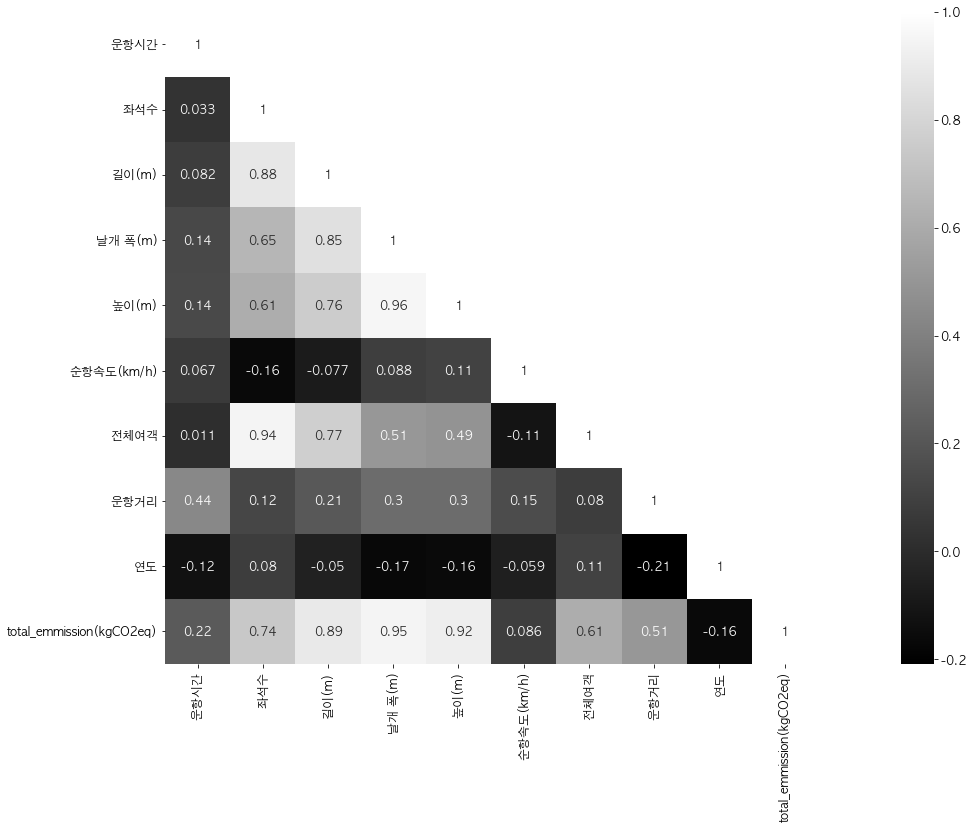

In [ ]:
plt.figure(figsize=(20, 20))
mask = np.array(total_data[numerical_feats].corr())
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=total_data[numerical_feats].corr(),mask=mask,square=True,annot=True,cbar=True, cmap='gray')

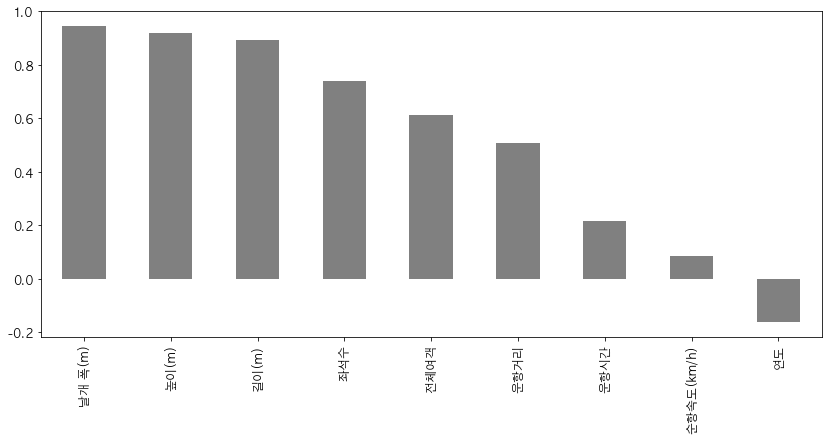

In [ ]:
plt.figure(figsize=(14,6))
corr = total_data[numerical_feats].corr()['total_emmission(kgCO2eq)'].sort_values(ascending=False)
corr.drop('total_emmission(kgCO2eq)').plot(kind='bar', color='gray')
plt.show()

In [ ]:
corr

total_emmission(kgCO2eq)    1.000000
날개 폭(m)                     0.946247
높이(m)                       0.917536
길이(m)                       0.891798
좌석수                         0.737312
전체여객                        0.611804
운항거리                        0.506272
운항시간                        0.217081
순항속도(km/h)                  0.085895
연도                         -0.162291
Name: total_emmission(kgCO2eq), dtype: float64

- 전체여객수 변수는 좌석수 변수를 통해 생성했고, 두 변수 사이에 상관관계가 매우 높게 측정되었기 때문에 둘 중에 하나의 변수를 삭제해줘야 된다.  

### 3) 데이터 전처리

In [ ]:
total_data['운항시간'].value_counts()

 70      7628
 60      2979
 55      2388
 65      1339
 75       870
 50       173
 80        61
 95        20
 90        15
 85        11
 45         7
 20         6
 100        4
 40         4
 105        3
 185        2
 1145       1
-50         1
 505        1
 10         1
 475        1
Name: 운항시간, dtype: int64

- 운항거리가 비상정적인 행들이 존재 -> 행 삭제

In [ ]:
s = total_data.loc[total_data['운항시간']== -50, :].index
total_data.drop(s, inplace=True)

s = total_data.loc[total_data['운항시간']== 1145, :].index
total_data.drop(s, inplace=True)

s = total_data.loc[total_data['운항시간']== 505, :].index
total_data.drop(s, inplace=True)

s = total_data.loc[total_data['운항시간']== 475, :].index
total_data.drop(s, inplace=True)

total_data.reset_index(drop=True, inplace=True)

In [ ]:
# 좌석수 열 삭제
X = total_data.drop(['total_emmission(kgCO2eq)', '좌석수'], axis=1)

In [ ]:
## 종속 변수 지정
y = total_data['total_emmission(kgCO2eq)']

In [ ]:
# 수치로 되어 있는 범주형 변수 데이터 속성 변경(인코딩 해주기 위해)
X['연도'] = X['연도'].astype('object')

In [ ]:
# 수치형 변수
numerical_feats = list(X.select_dtypes(exclude='object'))

# 범주형 변수
cat_feats = list(X.select_dtypes(include='object'))

In [ ]:
# # 레이블 인코딩
# for cat_name in cat_feats:
#     encoder = LabelEncoder()
#     label = encoder.fit_transform(X[cat_name])
#     X[cat_name] = label

In [ ]:
# 원핫 인코딩 <- 성능이 훨씬 잘나온다.
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# 표준화 <- 성능 오히려 떨어짐

# # StandardScaler객체 생성
# scaler = StandardScaler()


# # StandardScaler로 객체 데이터 변환, fit()과 transform() 호출.
# X_scaled = scaler.fit_transform(X)

# # transform()시 스케일 변환된 데이터 세트가 Numpy ndarray로 반환돼 이를 DataFrame으로 변환
# X = pd.DataFrame(data=X_scaled, columns=X.columns)

In [ ]:
# 정규화 <- 성능 향상

scaler = MinMaxScaler()

# MinMaxScaler로 데이터 세트 변환. fit()과 transform()호출.
X_scaled = scaler.fit_transform(X)

# transform()시 스케일 변환된 데이터 세트가 Numpy ndarray로 반환돼 이를 DataFrame으로 변환
X = pd.DataFrame(data=X_scaled, columns=X.columns)


### 4) 모델링

#### 4-1 데이터 분할

In [ ]:
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [ ]:
# 성능 지표를 출력하는 함수 구현
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def mape(y, pred):
    return mean_absolute_percentage_error(y, pred)


def evaluate_regr(model, y, pred):
    model_name = model.__class__.__name__
    mse_val = mean_squared_error(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    mape_val = mape(y, pred)

    return model_name, mse_val, rmse_val, mae_val, mape_val

# 모델과 학습/테스트 데이터 세트를 입력하면 성능, 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred = pred.astype('int')
    return evaluate_regr(model, y_test, pred)



# 모델의 성능들을 데이터표로 나타내주는 함수
def models_matrix_df(models):
    data_list = []
    for model in models:
        # XGboost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 반환
        model_name, mse_val, rmse_val, mae_val, mape_val = get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values)
        data_list.append([model_name, round(mse_val, 4),round(rmse_val, 4), round(mae_val, 4), round(mape_val, 4)])

    return pd.DataFrame(data=data_list, columns=['MODEL', 'MSE', 'RMSE', 'MAE', 'MAPE'])

def get_top_bottom_coef(model, n=7):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 컬럼명
    coef = pd.Series(model.coef_, index=X.columns)

    # + 상위 10개, - 하위 10개의 회귁 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개의 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(34, 20), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개의 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barcher로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiencents', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(20)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])




#### 4-2 모델 구현 및 평가

In [ ]:
# 디중 선형 회귀 모델 사용
lr_reg = LinearRegression()

# 규제 모델 Ridge, Lasso, ElasticNet 학습, 예측, 비교
ridge_reg = Ridge(alpha=1)

lasso_reg = Lasso(alpha=0.5)

elastic_reg = ElasticNet(alpha=0.001, l1_ratio=0.6)

# 앙상블 모델 랜덤포레스트, XGboost, LightGBM
rf_reg = RandomForestRegressor(max_depth=5, max_leaf_nodes=70, bootstrap=0.8)


xgb_reg = XGBRegressor(max_depth=5, learning_rate=0.05)
# learning_rate=0.0

lgbm_reg = LGBMRegressor(max_depth=5,  learning_rate=0.05, num_leaves=70,  subsample=0.7)

models = [lr_reg, ridge_reg, lasso_reg, elastic_reg, rf_reg, xgb_reg, lgbm_reg]

matrix_result = models_matrix_df(models)
matrix_result

,MODEL,MSE,RMSE,MAE,MAPE
0,LinearRegression,14413.0348,120.0543,73.7083,1.0087
1,Ridge,15588.6201,124.8544,77.7052,1.0645
2,Lasso,16255.9280,127.4987,77.2672,1.0630
3,ElasticNet,19566.9698,139.8820,89.2609,1.2092
4,RandomForestRegressor,9352.1009,96.7063,38.3234,0.5285
5,XGBRegressor,3625.0409,60.2083,51.0379,0.6607
6,LGBMRegressor,2638.5596,51.3669,20.8829,0.2552


- 과적합을 줄이기 위해, 규제모델의 파라미터를 조정하여 편차를 늘리고 분산을 감소시켜보자.

- 규제모델의 회귀계수 순위별 그래프

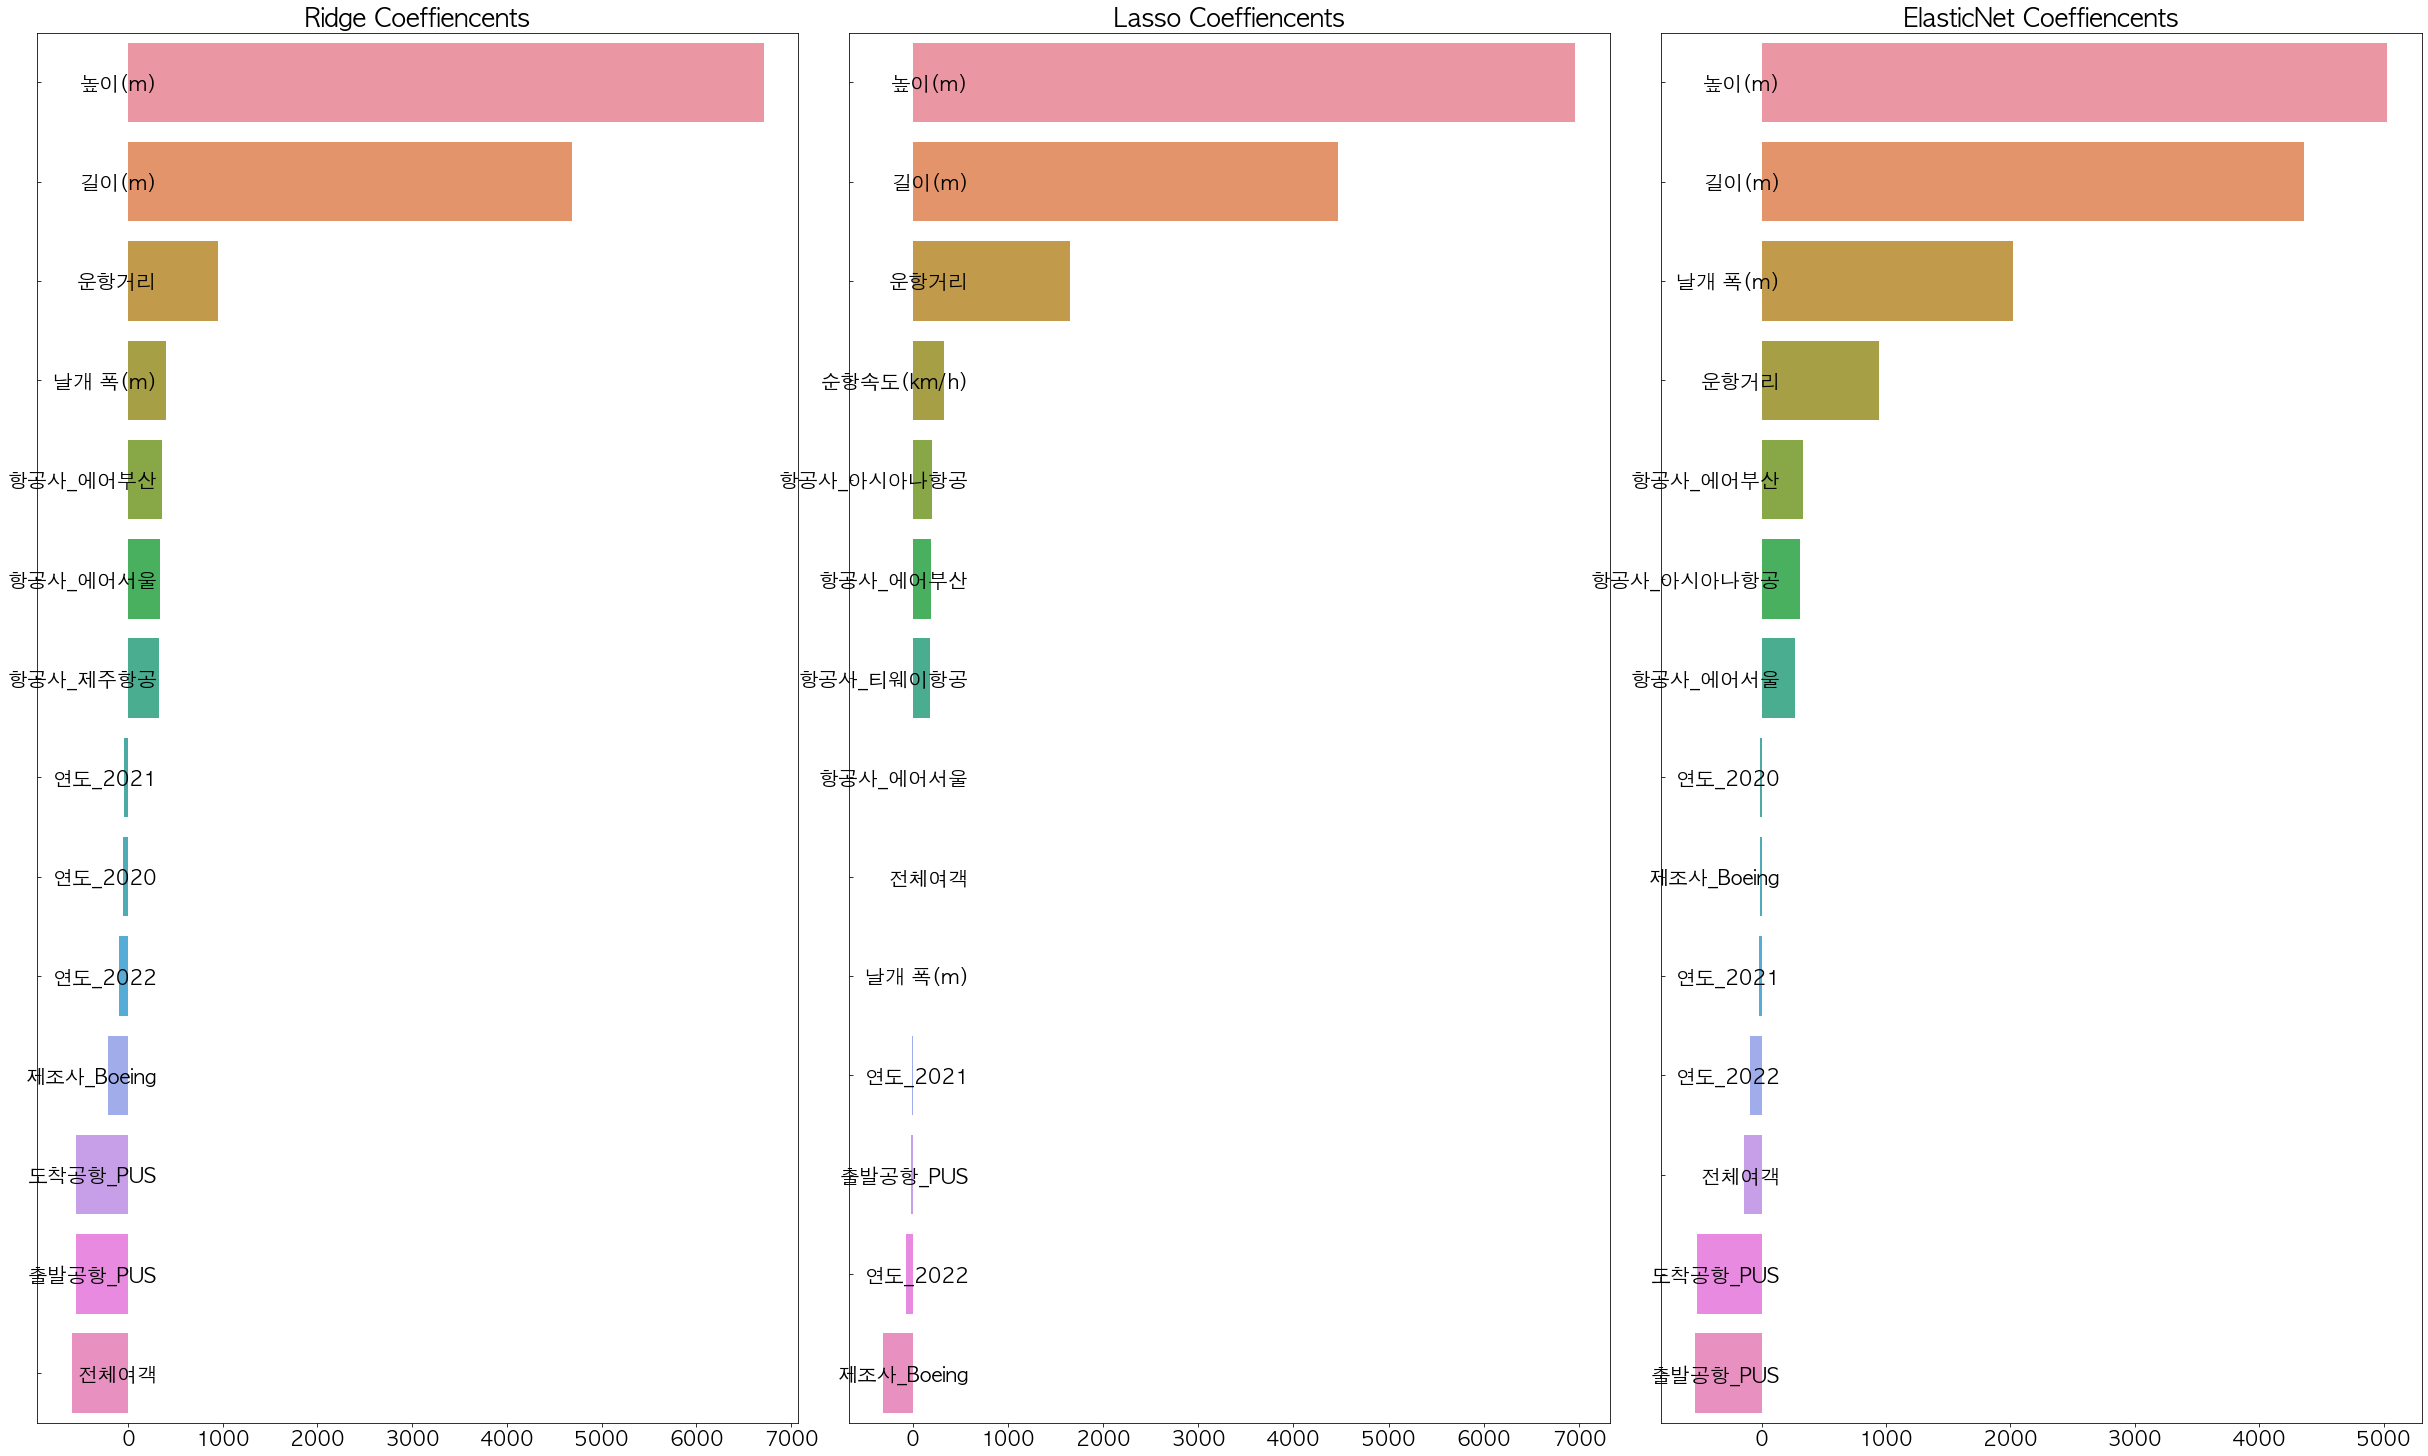

In [ ]:
visualize_coefficient(models[1:4])

- Lasso는 영향이 적은 변수들을 제거해주는 효과가 있다.

#### 4-3 교차검증

In [ ]:
# 교차검증 결과를 return하는 함수 구현
def get_avg_rmse_cv(models):

    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE 값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_train.values, y_train.values, scoring='neg_mean_squared_error', cv=5))

        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞에서 학습한 모델들의 CV RMSE 값 출력
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [113.715 112.807 107.816 119.337 112.001]
LinearRegression CV 평균 RMSE 값: 113.135

Ridge CV RMSE 값 리스트: [122.507 119.293 113.947 125.099 113.597]
Ridge CV 평균 RMSE 값: 118.889

Lasso CV RMSE 값 리스트: [122.616 120.114 114.709 126.82  116.547]
Lasso CV 평균 RMSE 값: 120.161

ElasticNet CV RMSE 값 리스트: [138.173 133.81  128.594 138.393 125.985]
ElasticNet CV 평균 RMSE 값: 132.991

RandomForestRegressor CV RMSE 값 리스트: [ 88.302  94.904  89.096 101.456  84.152]
RandomForestRegressor CV 평균 RMSE 값: 91.582

XGBRegressor CV RMSE 값 리스트: [60.402 59.478 57.366 65.634 58.364]
XGBRegressor CV 평균 RMSE 값: 60.249

LGBMRegressor CV RMSE 값 리스트: [53.763 48.565 40.922 54.964 47.596]
LGBMRegressor CV 평균 RMSE 값: 49.162


- 선형회귀 모델에서는 Ridge 규제 모형이 앙상블 모델 중에서는 LightGBM이 가장 높은 성능을 보여준다.

#### 4-4 하이퍼파라미터 튜닝

In [ ]:
# 그리드 서치
# 규제 모델의 하이퍼파리미터중 가장 성능이 높게 나오는 파라미터 값 찾기

ridge_reg = Ridge()



ridge_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}


grid_model = GridSearchCV(ridge_reg, param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_train, y_train)


rmse = np.sqrt(-1*grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(ridge_reg.__class__.__name__, np.round(rmse, 3), grid_model.best_params_))

best_ridge_reg = grid_model.best_estimator_

Ridge 5 CV 시 최적 평균 RMSE 값:113.196, 최적 alpha:{'alpha': 0.005}


In [ ]:
lasso_reg = Lasso()

lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

grid_model = GridSearchCV(lasso_reg, param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_train, y_train)


rmse = np.sqrt(-1*grid_model.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(lasso_reg.__class__.__name__, np.round(rmse, 3), grid_model.best_params_))

best_lasso_reg = grid_model.best_estimator_

Lasso 5 CV 시 최적 평균 RMSE 값:113.195, 최적 alpha:{'alpha': 0.001}


In [ ]:
# # 그리드 서치
# # light_GBM 모델의 하이퍼파리미터중 가장 성능이 높게 나오는 파라미터 값 찾기

# lgbm_reg = LGBMRegressor()


# parameters = { "n_estimators": [100, 500, 1000],
#     "learning_rate": [0.01, 0.05, 0.1, 0.3],
#     'num_leaves':[20,60,100],
#     'reg_alpha':[0,0.01,0.03],
#     "max_depth": [5, 10, 15, 20]}
# grid_reg = GridSearchCV(lgbm_reg, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
# grid_reg.fit(X_train, y_train)



# best_lgbm_reg = grid_reg.best_estimator_

- lightGBM의 파라미터의 개수가 매우 많기 때문에, 그리드서치로 하나하나 파라미터의 조합을 계산하는데 시간이 너무 많이 소요된다. -> 랜덤 서치를 써보자

In [ ]:
# 랜덤 서치
# light_GBM 모델의 하이퍼파리미터중 가장 성능이 높게 나오는 파라미터 값 찾기
lgbm_reg = LGBMRegressor()


parameters = { "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    'num_leaves':[20,60,100],
    'reg_alpha':[0,0.01,0.03],
    "max_depth": [5, 10, 15, 20]}

# 시간이 너무 오래 소요되기 떄문에, 랜덤 서치로 돌려준다.
grid_reg = RandomizedSearchCV(lgbm_reg, param_distributions=parameters,  n_iter=50, n_jobs=-1,scoring='neg_mean_squared_error')
grid_reg.fit(X, y)

rmse = np.sqrt(-1*grid_reg.best_score_)
print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(lgbm_reg.__class__.__name__, np.round(rmse, 3), grid_reg.best_params_))

best_lgbm_reg  = grid_reg.best_estimator_

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:173.175, 최적 alpha:{'reg_alpha': 0.03, 'num_leaves': 20, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05}


In [ ]:
# 하이퍼 파라미터를 튜닝한 모델들에 test 데이터를 입력하여 다시 평가
models = [best_ridge_reg, best_lasso_reg, best_lgbm_reg]


tuning_matrix_result = models_matrix_df(models)
tuning_matrix_result

,MODEL,MSE,RMSE,MAE,MAPE
0,Ridge,14419.8319,120.0826,73.6819,1.0083
1,Lasso,14419.0054,120.0792,73.6909,1.0084
2,LGBMRegressor,25.4915,5.0489,1.1164,0.0141


- 이전보다 큰 폭으로 성능이 향상되었다.

In [ ]:
# 이전 성능 결과
matrix_result

,MODEL,MSE,RMSE,MAE,MAPE
0,LinearRegression,14413.0348,120.0543,73.7083,1.0087
1,Ridge,15588.6201,124.8544,77.7052,1.0645
2,Lasso,16255.9280,127.4987,77.2672,1.0630
3,ElasticNet,19566.9698,139.8820,89.2609,1.2092
4,RandomForestRegressor,9352.1009,96.7063,38.3234,0.5285
5,XGBRegressor,3625.0409,60.2083,51.0379,0.6607
6,LGBMRegressor,2638.5596,51.3669,20.8829,0.2552
